# GPU Computing for Value Function Iteration in OpenCL
### Original Paper: "Tapping the Supercomputer Under Your Desk: Solving Dynamic Equilibrium Models with Graphics Processors"

## Preparing the Environment

We first import the OpenCL.jl modeule into the Julia workspace, and we make sure that the machine is equipped with a GPU device to run the task:

In [1]:
using OpenCL

cl.devices()

2-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz on Apple @0x00000000ffffffff)
 OpenCL.Device(Intel(R) Iris(TM) Graphics 550 on Apple @0x0000000001024500)          

In this case the 2nd device is an Intel GPU (Iris 550): since Intel graphic cards are not programmable with the CUDA GPGPU language, we resort to OpenCL, which runs with little performance overhead on prectically *any* consumer available graphics card.

## Creating the Kernel

The key component in any GPGPU program is the so-called **kernel**: a kernel is nothing more than a small, compact routine that instead of running on the CPU, that is **serially**, is dispatched to the GPU by the OpenCL program and run **at the same time** by all available cores.

The downside of the GPU is that all of its cores are "tied together", which means only tasks that can be split into indipendent, small-scale problems can benefit from being run on the GPU. In fact, most of the complexity in GPGPU computing is usually connected to the correct and most efficient orchestration of the CPU and the GPU.

Let us now define the **Value Function Iteration** algorithm as an OpenCL kernel:

In [2]:
vfi_cl = "
__kernel void gpuvfi( __global float *V0,
                      __global float *V,
                      __global const float *grid,
                      const int grid_size) 
{
      
        int gid = get_global_id(0);

        float alpha = 0.5f;
        float beta = 0.7f;
        
        float grid_p = grid[gid];

        float V_tmp = -INFINITY;
        float u_arg;
        float V_new;

        for(int i = 0; i <= grid_size; i++) {
            
            u_arg = pow(grid_p, alpha) - grid[i];
            
            if (u_arg > 0) {
                
                V_new = log(u_arg) + beta*V0[i];
                
                if (V_tmp < V_new) {
                    
                    V_tmp = V_new;
                    
                }
                
            } else {
                
                break;
                
            }

        }

         V[gid] = V_tmp;
    
}
";

Since the GPU is not capable of running high-level operations like numerical optimisation routines, we have to resort to a simple, direct maximization algorithm.

In this case the code contains a **hard coded** version of the Bellman's equation, with parameters and functional forms in explicit OpenCL mathematical commands: OpenCL code being very close to C as of operations allowed, there is no way to determine "inline functions" like one can do, for example, in both MATLAB and Julia. It would be also quite resource intensive, and here we are trying to produce a as-stripped-down-as-possible version of the VFI algorithm.

The GPU possesses a *global* and a *local* memory: both have different acces properties and are usuaally jointly used. However, the VFI requires to check, for every point in the capital grid, potentially every other possible point on such grid: we do not know *a priori* if we can restrict to a particular subset. Thus, the need to use *global* vectors for `grid`, `V0` and `V`.

We first identify the worker's "position" on the grid:
```c
int gid = get_global_id(0);
```
the we set `alpha` and `beta` at the required value, and we obtain the current capital grid value:
```c
float grid_p = grid[gid];
```
Starting `V_temp = -INFINITY` implies that we have an obvious lower bound, and any negative value, for little it may be, will be saved if necessary.

Interestingly, here we do not vectorize or pre-allocate operations: the GPU is extremely swift in executing these loops, but single kernels lack the trove of memory that is usually connected to the CPU. In a sense, GPU computing is more about **distributing** the computational burden more that **optimizing** it.

But to keep the loop efficient, we use a `break` command to automatically stop the kernel if the argument of the utility is negative: since the capital grid values are increasing in the inxed `i`, as soon as we meet a negative value we know that given the functional for of the utility and production function any further capital grid point will again be negative. Thus we stop the execution and return the optmized value into the GPU memory.

## Capital discretization:

We chose the lower bound **lb** and the upper bound **ub** for the capital: we will evenly discretize the interval between the bounds with **grid_size = 1000** points:

In [3]:
lb = 0.001;
ub = 10;

grid_size = 1000;

grid_w = Array{Float32}(collect(linspace(lb, ub, grid_size)));

In [4]:
function opencl_vfi(grid_::Array{Float32}, lowb_::Any, upb_::Any, maxiter_::Any, prec_::Any)
    
    device, ctx, queue = cl.create_compute_context();
    
    # Load OpneCL Kernel from a file:
    #
    # vfi_cl = readstring(joinpath(pwd(), "vfi_correct.cl"));
    
    V0 = Array{Float32}(zeros(size(grid_)));
    V = Array{Float32}(zeros(size(grid_)));
    
    grid_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = grid_);
    V0_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = V0);
    V_buff = cl.Buffer(Float32, ctx, :w, length(V));

    p = cl.Program(ctx, source = vfi_cl) |> cl.build!  # Using the CORRECT kernel;
    krn = cl.Kernel(p, "gpuvfi")
    
    V0 = ones(size(V0));
    V0_ = zeros(size(V0));
    
    it = 0;
    
    while ( norm(V0 - V) > prec_ && it < maxiter_)
        
        copy!(V0, V);
        
        krn[queue, size(grid_)](V0_buff, V_buff, grid_buff, 1000)
        
        V = cl.read(queue, V_buff);
        
        V0_ = cl.read(queue, V0_buff);
        
        cl.copy!(queue, V0_buff, V_buff);
        
        it += 1;
        
    end
    
    return V, it
    
end

opencl_vfi (generic function with 1 method)

In [5]:
using Optim
using Interpolations

function cpu_vfi(grid_::Array{Float32}, lowb_::Any, upb_::Any, maxiter_::Any, prec_::Any)
    
    w_prev = ones(size(grid_));
    w_ = zeros(size(grid_));
    
    alpha = 0.5;
    beta = 0.7;
    
    it = 0;
    
    while ( sum(abs.(w_prev - w_)) > prec_ && it < maxiter_ )
        
        w_prev = copy(w_);
        
        for (i, point_i) in enumerate(grid_)
            
           w_max = -Inf;
            for (j, point_j) in enumerate(grid_)
                cons = (grid_[i].^alpha - point_j);
                if cons > 0
                    w_max = max(w_max, (log(cons) + beta*w_prev[j]));
                end
            end

            w_[i] = w_max;
            
        end
        
        it += 1;

    end

    return w_, it
     
    
end

cpu_vfi (generic function with 1 method)

## Comparing algorithm speed

In [6]:
@time w_gpu, it_gpu = opencl_vfi(grid_w, lb, ub, 1000, 0.00001)

  1.347665 seconds (566.99 k allocations: 31.217 MiB, 0.62% gc time)


(Float32[-8.63812, -6.79475, -6.29169, -5.99307, -5.77733, -5.60927, -5.47292, -5.35522, -5.25326, -5.1644  …  -1.55614, -1.55536, -1.55458, -1.55381, -1.55303, -1.55226, -1.55148, -1.55071, -1.54994, -1.54916], 46)

In [7]:
@time w_cpu, it_cpu = cpu_vfi(grid_w, lb, ub, 1000, 0.00001)

  2.071380 seconds (74.44 k allocations: 4.838 MiB)


([-8.63812, -6.79476, -6.29169, -5.99308, -5.77733, -5.60927, -5.47292, -5.35522, -5.25326, -5.1644  …  -1.55614, -1.55536, -1.55459, -1.55381, -1.55304, -1.55226, -1.55148, -1.55071, -1.54994, -1.54916], 55)

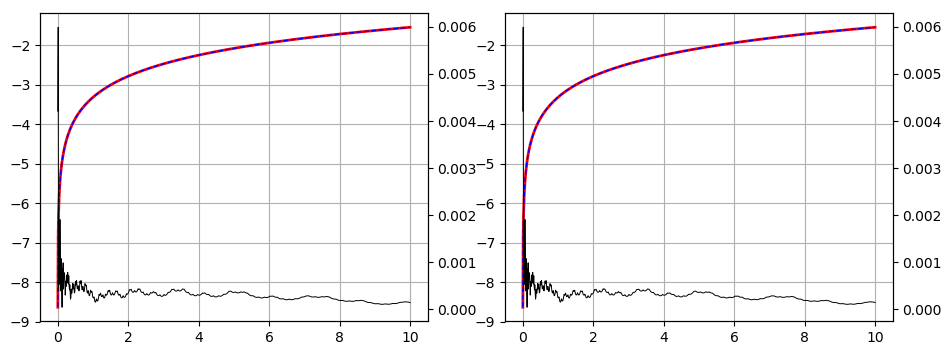

In [8]:
alpha = 0.5;
beta = 0.7;
ab = alpha*beta;
y = log(1-alpha*beta)/(1-beta) + (alpha*beta*log(alpha*beta))/((1-beta)*(1-alpha*beta)) + alpha/(1-alpha*beta)*log.(grid_w);
z = alpha/(1-ab)*log.(grid_w);

error_gpu = abs.((y-w_gpu)./(1 + abs.((y-w_gpu))));
error_cpu = abs.((y-w_cpu)./(1 + abs.((y-w_cpu))));

using PyPlot

fig = figure(figsize=(11,4));

ax_a = subplot(121);

ax_a1 = twinx(ax_a)

ax_a[:plot](grid_w, w_gpu, "r-", linewidth=2);
ax_a[:plot](grid_w, y, "b--", linewidth=1);
ax_a1[:plot](grid_w, error_gpu, "k", linewidth=0.7);
ax_a[:grid](true);

ax_b = subplot(122);

ax_b1 = twinx(ax_b)

ax_b[:plot](grid_w, w_cpu, "r-", linewidth=2);
ax_b[:plot](grid_w, y, "b--", linewidth=1);
ax_b1[:plot](grid_w, error_cpu, "k", linewidth=0.7);
ax_b[:grid](true);

In [9]:
av_gpu_time = 0;
av_cpu_time = 0;

repeats = 3;

for i in 1:repeats
    
    t_gpu = @elapsed opencl_vfi(grid_w, lb, ub, 1000, 0.0001)
    t_cpu = @elapsed cpu_vfi(grid_w, lb, ub, 1000, 0.0001)
    
    av_gpu_time += t_gpu/repeats;
    av_cpu_time += t_cpu/repeats;
    
end

"Done"

"Done"

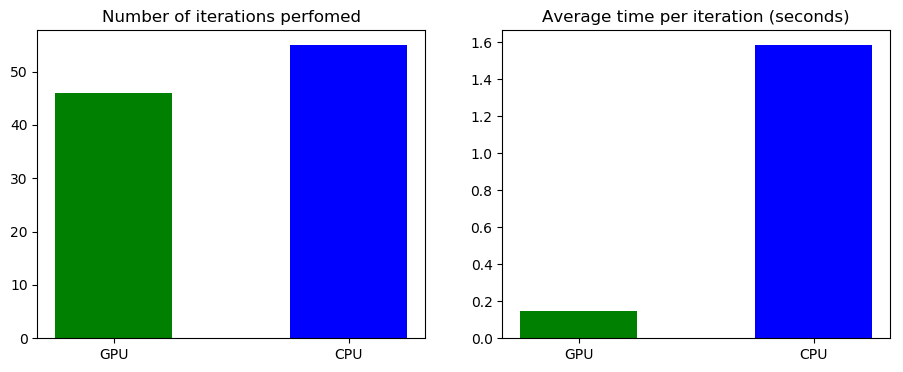

In [10]:
using PyPlot;

fig, ax = subplots(figsize=(11,4));

ax_a = subplot(121)

bar([1, 2], [it_gpu, it_cpu], tick_label=["GPU", "CPU"], color=["g", "b"], width=0.5);
title("Number of iterations perfomed");

ax_b = subplot(122)

bar([1, 2], [av_gpu_time, av_cpu_time], tick_label=["GPU", "CPU"], color=["g", "b"], width=0.5);
title("Average time per iteration (seconds)");
